# SET UP

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

2021-10-11 15:23:23.530318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-11 15:23:23.530370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255

    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    return PIL.Image.fromarray(tensor)

In [50]:
content_path = tf.keras.utils.get_file('covid_test.png', 'file:/home/sydney/Projects/2021_SELF_STUDY/2021_SELF_STUDY/Python_Practices/해커톤 연습 폴더/real_objects/covid_test.png')
style_path = tf.keras.utils.get_file('pattern9.jpg','file:/home/sydney/Projects/2021_SELF_STUDY/2021_SELF_STUDY/Python_Practices/해커톤 연습 폴더/images/pattenrs9.jpg')

90112/74369 [====================================] - 0s 0us/step


# VISUALIZE THE INPUT

In [51]:
def load_img(path_to_img, dim):
    max_dim = dim

    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

In [52]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

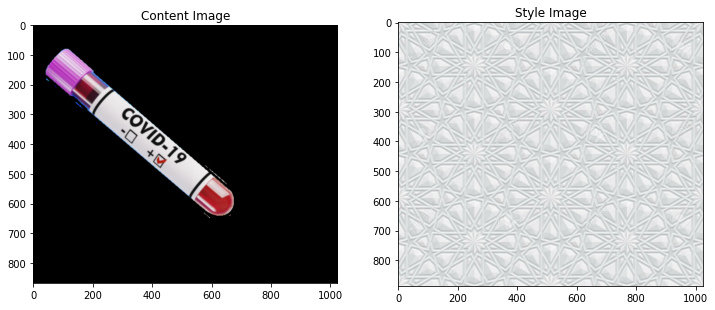

In [53]:
content_image = load_img(content_path, 1024)
style_image = load_img(style_path, 1024)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# FAST STYLE TRANSFER USING TF-HUB

# DEFINE CONTENT AND STYLE REPRESENTATIONS

In [54]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [55]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('syringe', 0.3228748),
 ('ballpoint', 0.22445245),
 ('lipstick', 0.11981979),
 ('screwdriver', 0.07733263),
 ('lighter', 0.054810956)]

In [56]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()

for layer in vgg.layers:
  print(layer.name)


input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [57]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### BUILDING THE MODEL

In [58]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [59]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 886, 1024, 64)
  min:  0.0
  max:  861.46375
  mean:  32.37553

block2_conv1
  shape:  (1, 443, 512, 128)
  min:  0.0
  max:  3198.945
  mean:  178.32799

block3_conv1
  shape:  (1, 221, 256, 256)
  min:  0.0
  max:  9659.357
  mean:  150.61804

block4_conv1
  shape:  (1, 110, 128, 512)
  min:  0.0
  max:  13657.037
  mean:  604.9052

block5_conv1
  shape:  (1, 55, 64, 512)
  min:  0.0
  max:  2116.9023
  mean:  42.449844



### CACULATE STYLE

In [60]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### EXTRACT STYLE AND CONTENT

In [61]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                        outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [62]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  81773.59
    mean:  607.1924

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  87698.91
    mean:  12864.676

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  354555.72
    mean:  8957.75

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3402493.2
    mean:  128633.67

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  30638.129
    mean:  371.50586

Contents:
   block5_conv2
    shape:  (1, 54, 64, 512)
    min:  0.0
    max:  892.01605
    mean:  4.5978227


In [63]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [64]:
image = tf.Variable(content_image)

In [65]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [66]:
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)

In [67]:
style_weight=1e-2
content_weight=1e4

In [68]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [69]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

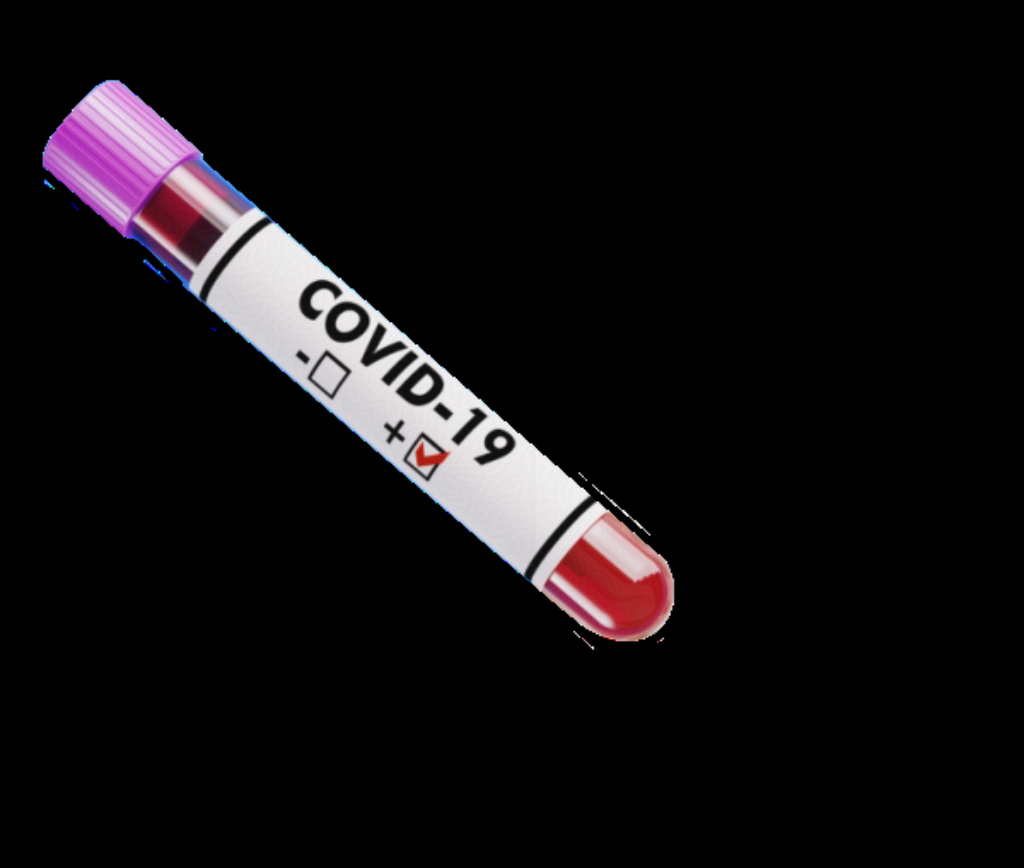

In [70]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

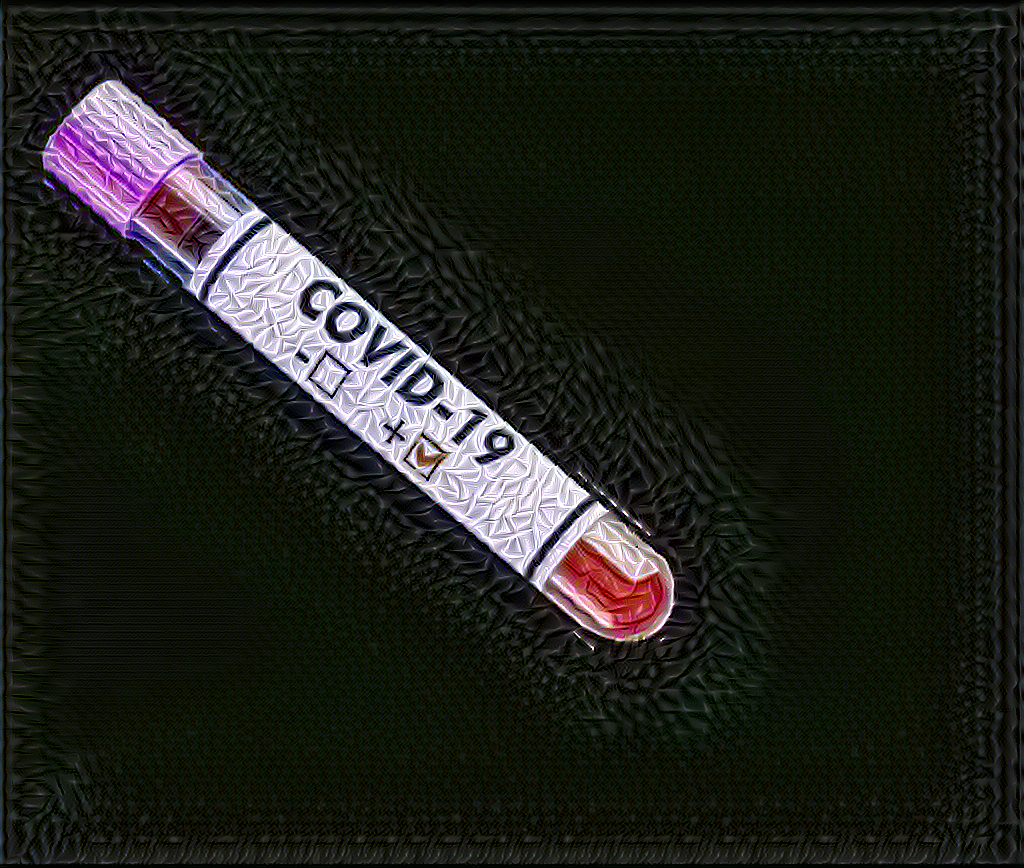

Train step: 300
Total time: 2375.8


In [72]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 30

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [26]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

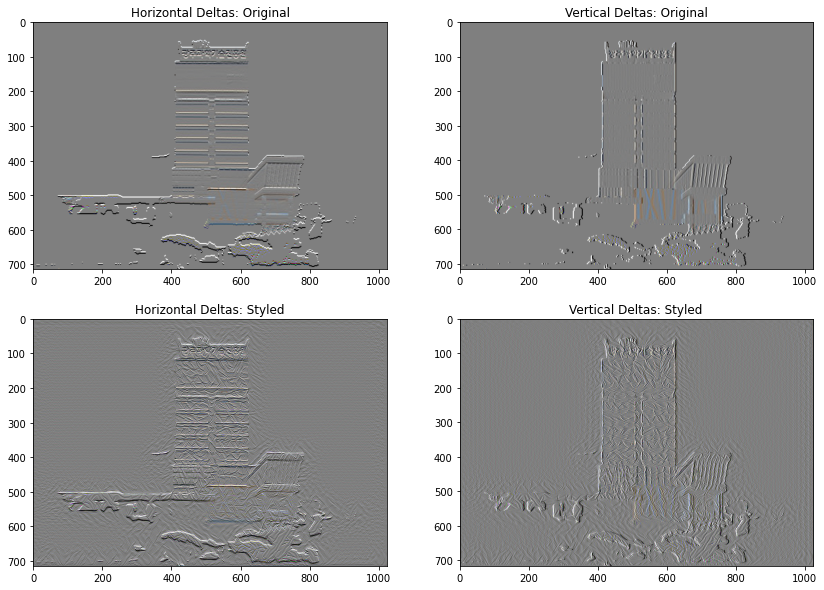

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")